In [15]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [17]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.layers import Conv1D, Flatten,MaxPooling1D
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc




In [18]:
# Importing the csv data files 
sarcasm_df = pd.read_csv('data/train-balanced-sarcasm.csv')
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [19]:
# Data Pre-Processing
# Removing the null comments
sarcasm_df.dropna(subset=['comment'], inplace=True)
sarcasm_df['comment'] = sarcasm_df['comment'].str.lower()
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')

In [20]:
# Converting the timestamp into DateTime object
sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  object        
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


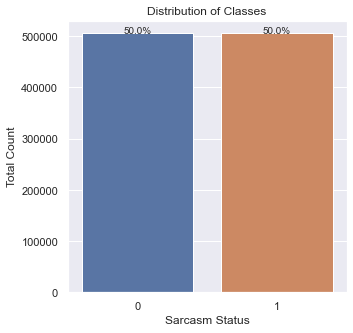

In [21]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= sarcasm_df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

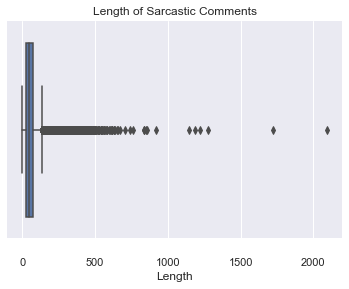

In [22]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

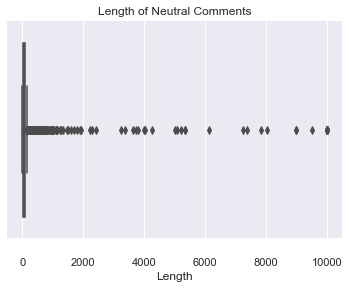

In [23]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

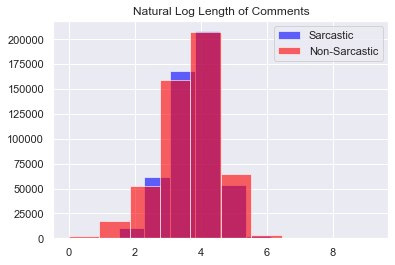

In [24]:
sarcasm_df['log_comment'] = sarcasm_df['comment'].apply(lambda text: np.log1p(len(text)))
sarcasm_df[sarcasm_df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue')
sarcasm_df[sarcasm_df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

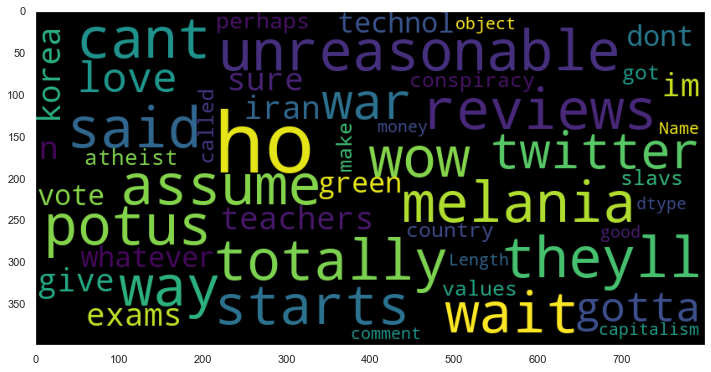

In [25]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

In [26]:
# Converting the scores into numpy array
sarcasm_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['score'])
neutral_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 0]['score'])

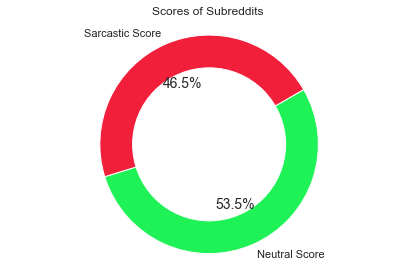

In [27]:
# Displaying the distribution of  Status in a Pie chart
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']
 
plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.tight_layout()
plt.show()

In [28]:
sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())/(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))

In [29]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

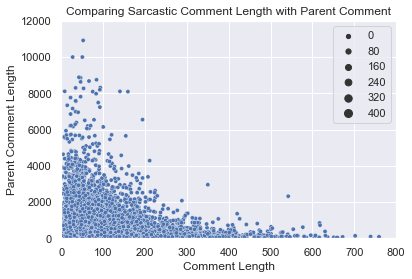

In [30]:
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

In [31]:
# Getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

AskReddit          65674
politics           39493
worldnews          26376
leagueoflegends    21034
pcmasterrace       18987
Name: subreddit, dtype: int64

In [32]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']


In [33]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [34]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

c:\users\avimo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\avimo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\avimo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

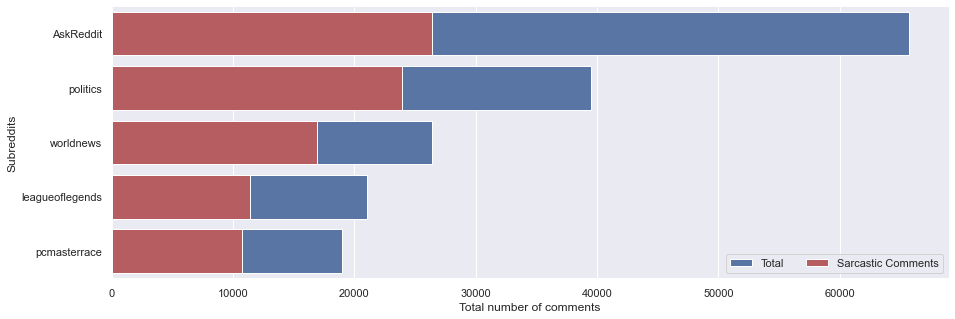

In [35]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

In [36]:
# Feature Engineering- Extracting the day of a week
sarcasm_df['created_utc'] = pd.to_datetime(sarcasm_df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
sarcasm_df['Day of Week'] = sarcasm_df['created_utc'].dt.day_name()

In [37]:
#modeling using logistic regression
logit = LogisticRegression(random_state= 42)

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(sarcasm_df['comment'])
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, sarcasm_df['label'], random_state=42)



logit.fit(x_train, y_train)

c:\users\avimo\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [26]:
predicted_class=logit.predict(x_test)
predicted_class_train=logit.predict(x_train)
test_probs = logit.predict_proba(x_test)
test_probs = test_probs[:, 1]
yhat = logit.predict(x_test)
train_accuracy = accuracy_score(y_train,predicted_class_train)
test_accuracy = accuracy_score(y_test,predicted_class)
print("Train accuracy score: ", train_accuracy*100,"%")
print("Test accuracy score: ",test_accuracy*100,"%" )
print()

Train accuracy score:  72.29945691675933 %
Test accuracy score:  69.3767956500748 %



In [27]:
#using bidirectional LSTM

sarcasm_df.reset_index(drop = True, inplace = True)
corpus = [sarcasm_df['comment'][i] for i in range( len(sarcasm_df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length = 20

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40

X_final=np.array(embedded_docs)
y_final=np.array(sarcasm_df['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [28]:
lstm_model=Sequential()
lstm_model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
lstm_model.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),epochs=10,batch_size=64)

Epoch 1/10
10582/10582 [==============================] - 517s 48ms/step - loss: 0.5906 - accuracy: 0.6809 - val_loss: 0.5715 - val_accuracy: 0.6983
Epoch 2/10
10582/10582 [==============================] - 518s 49ms/step - loss: 0.5672 - accuracy: 0.7021 - val_loss: 0.5659 - val_accuracy: 0.7018
Epoch 3/10
10582/10582 [==============================] - 555s 52ms/step - loss: 0.5573 - accuracy: 0.7090 - val_loss: 0.5632 - val_accuracy: 0.7028
Epoch 4/10
10582/10582 [==============================] - 596s 56ms/step - loss: 0.5497 - accuracy: 0.7148 - val_loss: 0.5617 - val_accuracy: 0.7051
Epoch 5/10
10582/10582 [==============================] - 611s 58ms/step - loss: 0.5433 - accuracy: 0.7195 - val_loss: 0.5611 - val_accuracy: 0.7067
Epoch 6/10
10582/10582 [==============================] - 3356s 317ms/step - loss: 0.5378 - accuracy: 0.7238 - val_loss: 0.5625 - val_accuracy: 0.7061
Epoch 7/10
10582/10582 [==============================] - 4266s 403ms/step - loss: 0.5332 - accuracy: 0.

In [41]:
# using convoluted nural networks
vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 1

In [39]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df['comment'], sarcasm_df['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [40]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Dropout(.5))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='relu'))
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])





In [ ]:

cnn_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1,batch_size=64)

 7310/10582 [===================>..........] - ETA: 10:52 - loss: 0.6195 - accuracy: 0.6505